In [1]:
import sys, os
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import torch
import sklearn

sys.path.append("../src/models/")
sys.path.append("../src/")

from utils import utils

from PIL import Image

def count_frames_in_tiff(tiffpath):
    with Image.open(tiffpath) as tiff_img:
        nframes = tiff_img.n_frames
    return nframes



def get_image_from_dataset(dataset, index):
    filename = dataset.file_list[index].split("/")[-1]
    dirname = "/".join(dataset.file_list[index].split("/")[:-1])
    dirname = dirname.replace("/split_images/shortTIFF/", "/sumTIFF/")
    path_average_image = os.path.join(dirname, f"{filename.split('__')[0]}.tiff")

    if os.path.exists(path_average_image) == False:
        path_average_image = path_average_image.replace(".tiff", ".tif")

    data_in_HD_2023_0511 = pd.read_csv("data_in_HD_2023-0511.csv")

    # for f in data_in_HD_2023_0511.filename:
    #     if "FoilHole_18713415_Data_18711474_18711476_20201219_063611" in f:
    #         print(f)
            

    print("count_frames_in_tiff of average_image", 
        count_frames_in_tiff(path_average_image))
        
    with Image.open(path_average_image) as tiff_img:
        tiff_img.seek(0)
        summed_extracted_image = np.array(tiff_img.copy(), 
                                )
        
    #original_n_frames = data_in_HD_2023_0511.query(f'filename=="{filename.split("__")[0]}.tiff"').nframes.item()        
    #averaged_extracted_image = summed_extracted_image / original_n_frames

    extracted_image = summed_extracted_image
    print("extracted_image.shape", extracted_image.shape)

    simple_process_image = utils.split_image(extracted_image)[(index % 100)].astype("float32")

    dd = dataset[index]
    return simple_process_image, dd


# Show images of (short_motionCor, original_motionCor, just_average)

In [2]:
def display_images(images, titles, num_rows, num_cols, imagemin=0, imagemax=40):
    from matplotlib.colors import Normalize
    from sklearn.preprocessing import MinMaxScaler
    assert len(images) == num_rows * num_cols, "Number of images should match num_rows * num_cols"

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 5, num_rows * 5))

    # If num_rows or num_cols is 1, axs is a 1-D array
    if num_rows == 1 or num_cols == 1:
        axs = axs.ravel()
    
    for idx in range(len(images)):
        image = images[idx]
        
        mmscaler = MinMaxScaler(feature_range=(imagemin, imagemax), copy=True)
        image = mmscaler.fit_transform(image.astype('float'))

        # norm = Normalize(vmin=imagemin, vmax=imagemax)

        axs[idx].imshow(image, cmap='gray', vmin=imagemin, vmax=imagemax,
                        #norm=norm
                        )
        axs[idx].set_title(titles[idx])
        axs[idx].axis('off')
        #if idx == len(images)-1:
        # fig.colorbar(plt.cm.ScalarMappable(cmap='gray'), ax=axs[idx])
                
    return fig, axs #plt.show()

def show_describe(data):
    # print(pd.Series(data.ravel()).describe())
    display(pd.Series(data.ravel()).describe().to_frame().T
            )

# Load model

In [3]:

sys.path.append("../src/models/")
from pretrain_srresnets_for_srgan import SRResNet

# ch_path = "/media/kyohei/forAI/lightning_logs/srresnet/version_5/checkpoints/epoch=19-step=3760.ckpt"
# ch_path = "/media/kyohei/forAI/lightning_logs/srresnet/version_9/checkpoints/epoch=29-step=5640.ckpt"
# model = SRResNet.load_from_checkpoint(ch_path)
# generator = model.eval()


/home/kyohei/miniconda3/envs/cryoem/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/kyohei/miniconda3/envs/cryoem/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task

In [4]:
from srgan import SRGAN


cpath = "/media/kyohei/forAI/lightning_logs/hpo_srgan/version_12/checkpoints/epoch=15-step=12000.ckpt"
cpath = "/media/kyohei/forAI/lightning_logs/hpo_srgan/version_21/checkpoints/best-checkpoint.ckpt"
cpath = "/media/kyohei/forAI/lightning_logs/srgan/version_0/checkpoints/best-checkpoint-v1.ckpt"
cpath =  '/media/kyohei/forAI/lightning_logs/srgan/version_0/checkpoints/best-checkpoint.ckpt'
model = SRGAN.load_from_checkpoint(cpath)

## ## eval mode to stop backprop
model = model.eval()

generator = model.generator.eval()


Global seed set to 1234
/home/kyohei/workspace/fastcryo/notebooks/../src/models/srgan.py:47: UnderReviewWarning: The feature ResidualBlock is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  res_blocks += [ResidualBlock(feature_maps)]
/home/kyohei/workspace/fastcryo/notebooks/../src/models/srgan.py:144: UnderReviewWarning: The feature SRGANDiscriminator is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.discriminator = SRGANDiscriminator(image_channels, feature_maps_disc)
/home/kyohei/workspace/fastcryo/notebooks/../src/mo

# Load test set

In [5]:
from srgan import MRCImageDataset
dataset = MRCImageDataset("/media/kyohei/forAI/split_images/",)

## Y-TRUE

INDEX = 2
TITLES = ["motionCor on short frames", "motionCor on original file", "simple_process_image",
         "prediction from short frames"]

simple_process_image, dd = get_image_from_dataset(dataset, INDEX)

## PREDICTION

x = torch.tensor(dd[0]).unsqueeze(0).unsqueeze(0) 

# ypred = generator(x)
ypred = model(x).detach().numpy()[0]



count_frames_in_tiff of average_image 1
extracted_image.shape (4092, 5760)


In [6]:
dataset.file_list[2].split("/")[-1], dataset.file_list[2]

('FoilHole_18713415_Data_18711474_18711476_20201219_063611_fractions__split2.mrc',
 '/media/kyohei/forAI/split_images/shortTIFF/10877/FoilHole_18713415_Data_18711474_18711476_20201219_063611_fractions__split2.mrc')

In [7]:
# filename = dataset.file_list[2].split("/")[-1]
# path_average_image = f"/media/kyohei/forAI/sumTIFF/10877/{filename.split('__')[0]}.tiff" 
# path_average_image


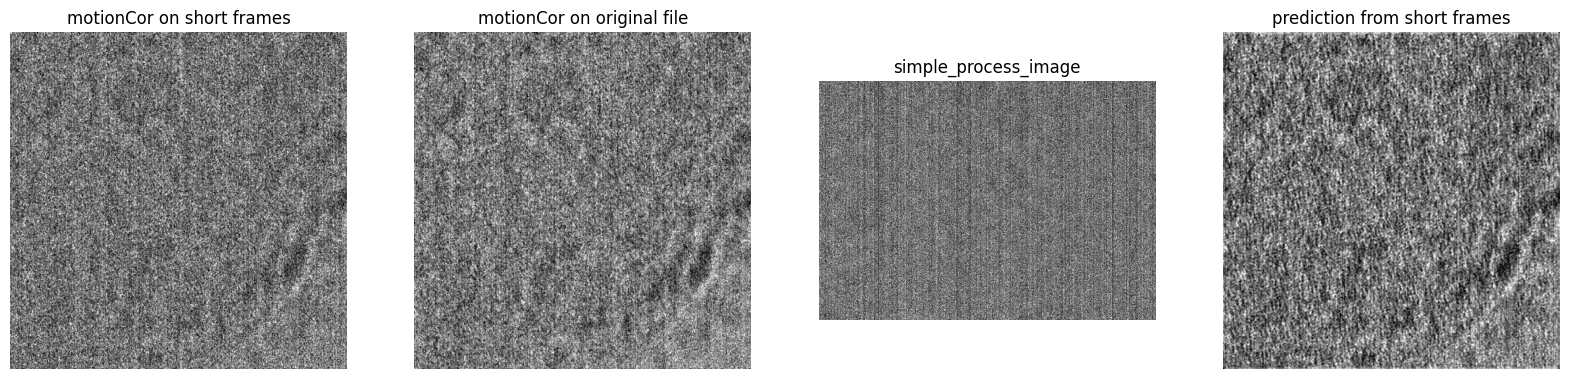

<Figure size 10000x20000 with 0 Axes>

In [8]:

images = dd + tuple([simple_process_image]) + tuple(ypred)
                          
fig, axs = display_images(images, 
                          TITLES, num_rows=1, num_cols=len(TITLES))
plt.figure(figsize=(100,200))
plt.show()

In [9]:
show_describe(dd[0]); show_describe(dd[1]); show_describe(simple_process_image); show_describe(ypred); 

count      mean      std       min       25%       50%       75%   
0  262144.0  7.847374  2.08482  0.286936  6.417354  7.753467  9.175948  \

         max  
0  16.669239

count       mean       std       min        25%        50%       75%   
0  262144.0  24.884502  4.133304  6.651968  22.061508  24.763496  27.56553  \

         max  
0  42.073662

count       mean       std  min   25%   50%   75%    max
0  235584.0  29.257242  5.662791  7.0  25.0  29.0  33.0  244.0

count      mean       std       min       25%      50%       75%   
0  262144.0  1.544267  0.499801 -0.354463  1.197466  1.52469  1.870989  \

        max  
0  3.967125

# for loop  of the several data indices

index 6374
count_frames_in_tiff of average_image 1
extracted_image.shape (4092, 5760)


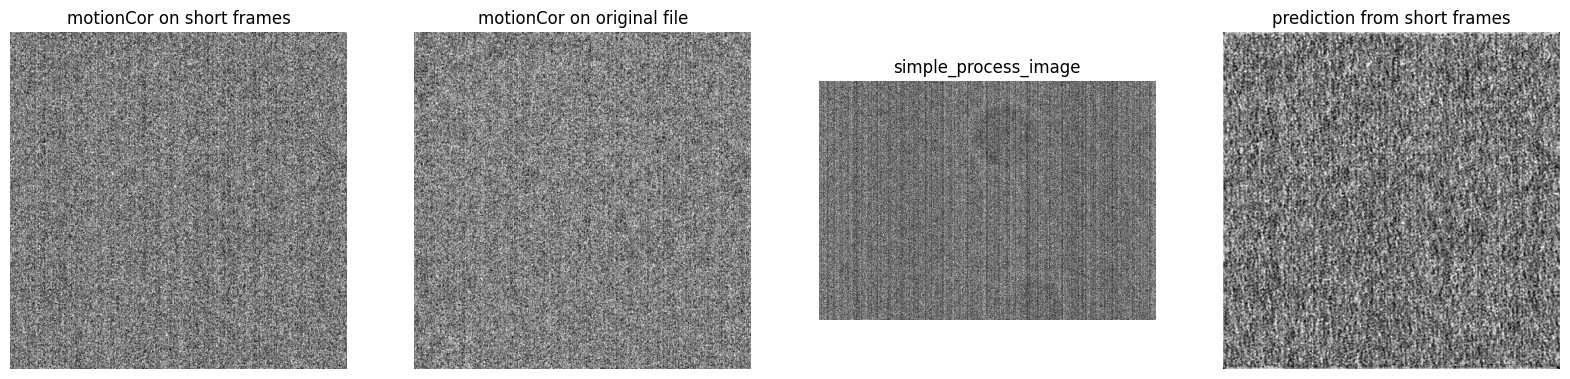

<Figure size 10000x20000 with 0 Axes>

count       mean       std       min       25%        50%        75%   
0  262144.0  10.238243  2.158024  0.940795  8.783557  10.187078  11.634068  \

         max  
0  18.194157

count       mean       std       min        25%        50%        75%   
0  262144.0  35.320145  4.039199  16.33436  32.629866  35.261135  37.955697  \

         max  
0  49.702042

count       mean       std  min   25%   50%   75%   max
0  235584.0  36.884106  6.414869  9.0  33.0  37.0  41.0  89.0

count      mean       std       min       25%      50%       75%   
0  262144.0  2.526997  0.467575  0.595112  2.205882  2.51474  2.834503  \

       max  
0  4.70545

index 3610
count_frames_in_tiff of average_image 1
extracted_image.shape (4092, 5760)


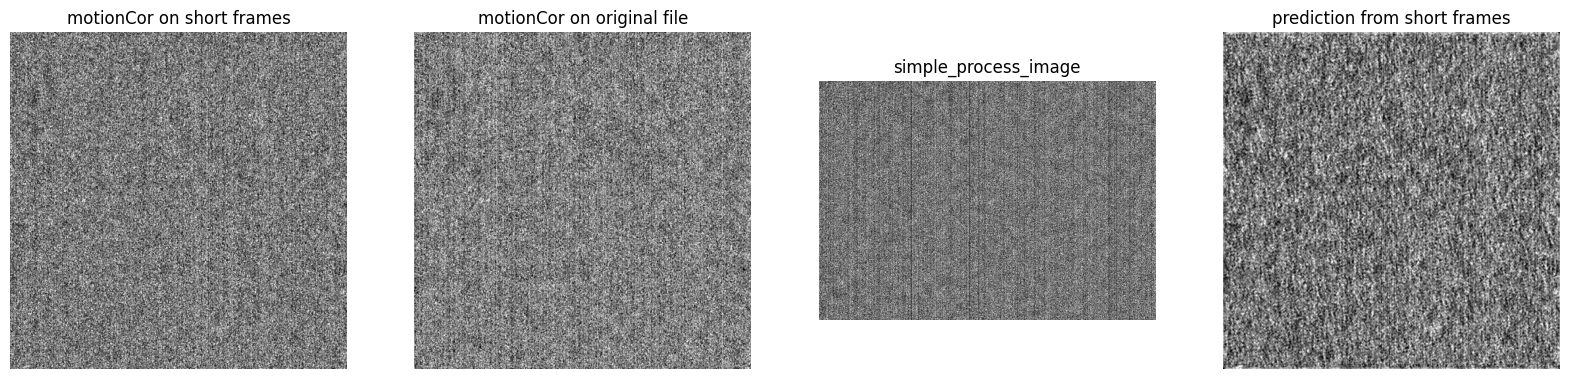

<Figure size 10000x20000 with 0 Axes>

count      mean       std       min       25%       50%        75%   
0  262144.0  9.627519  2.142686  0.928911  8.170913  9.557353  11.009349  \

        max  
0  17.64246

count       mean       std        min        25%        50%        75%   
0  262144.0  32.665661  4.000515  11.558599  29.982139  32.602692  35.285717  \

         max  
0  47.012917

count       mean       std  min   25%   50%   75%    max
0  235584.0  33.584843  6.029026  3.0  29.0  33.0  38.0  131.0

count      mean       std       min       25%       50%       75%   
0  262144.0  2.274998  0.475141  0.397037  1.947094  2.260858  2.587897  \

        max  
0  4.679745

index 957
count_frames_in_tiff of average_image 1
extracted_image.shape (4092, 5760)


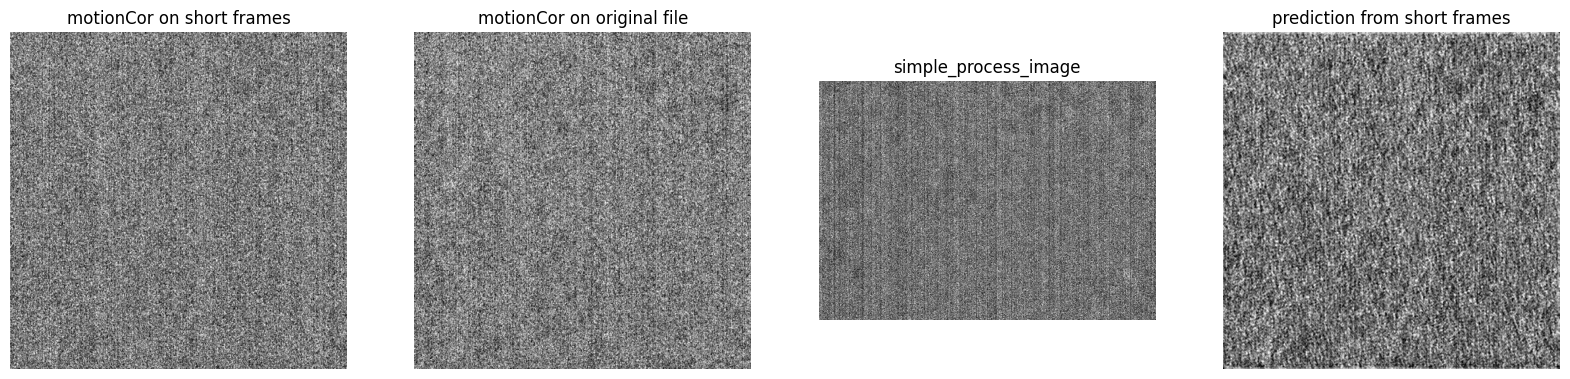

<Figure size 10000x20000 with 0 Axes>

count      mean       std       min       25%       50%        75%   
0  262144.0  9.290488  2.092469  0.644961  7.876143  9.226514  10.641989  \

         max  
0  17.077324

count      mean       std        min        25%        50%        75%   
0  262144.0  29.44039  3.801885  11.532849  26.885286  29.367554  31.927088  \

         max  
0  43.431877

count       mean       std  min   25%   50%   75%   max
0  235584.0  29.924719  5.739128  8.0  26.0  30.0  34.0  83.0

count      mean       std       min       25%       50%       75%   
0  262144.0  2.130191  0.463315  0.436411  1.809127  2.114319  2.434119  \

        max  
0  4.337631

index 61
count_frames_in_tiff of average_image 1
extracted_image.shape (4092, 5760)


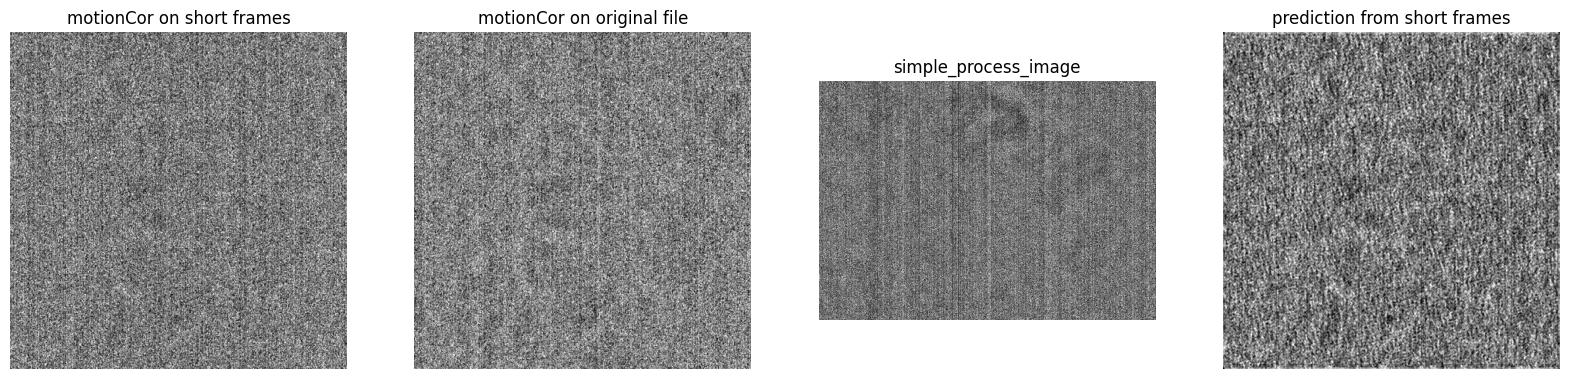

<Figure size 10000x20000 with 0 Axes>

count      mean       std       min      25%       50%        75%   
0  262144.0  9.193422  2.073716  0.475786  7.78546  9.128242  10.531796  \

         max  
0  16.669239

count       mean       std        min        25%        50%        75%   
0  262144.0  29.139853  3.747372  10.895755  26.637374  29.079343  31.576253  \

         max  
0  42.073662

count       mean       std  min   25%   50%   75%    max
0  235584.0  30.454462  5.767565  9.0  26.0  30.0  34.0  105.0

count      mean       std       min       25%       50%       75%   
0  262144.0  2.087579  0.453876  0.233266  1.773778  2.072171  2.386593  \

        max  
0  4.261965

index 742
count_frames_in_tiff of average_image 1
extracted_image.shape (4092, 5760)


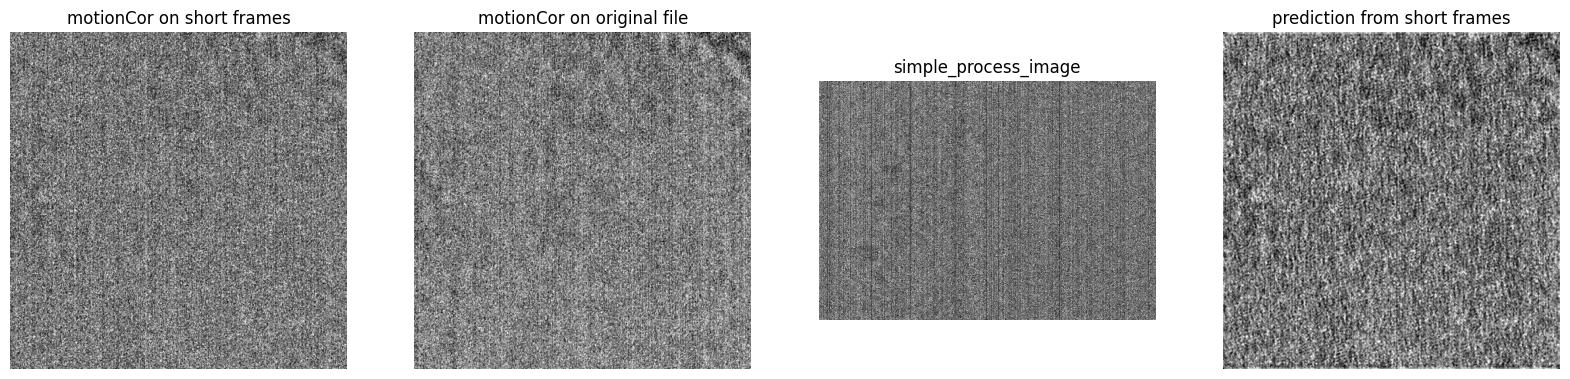

<Figure size 10000x20000 with 0 Axes>

count      mean     std       min       25%       50%       75%   
0  262144.0  8.552053  2.0342  0.428171  7.166284  8.474967  9.864798  \

         max  
0  16.487457

count       mean       std       min        25%        50%        75%   
0  262144.0  27.089911  3.742133  8.042216  24.599234  27.011967  29.518282  \

       max  
0  41.6642

count       mean       std  min   25%   50%   75%    max
0  235584.0  31.209883  5.904988  8.0  27.0  31.0  35.0  108.0

count      mean       std       min       25%       50%       75%   
0  262144.0  1.821172  0.449178  0.112666  1.510101  1.806789  2.115917  \

        max  
0  4.061223

In [10]:
import random
random_list = random.sample(list(range(len(dataset))), 5)

for iii in random_list:
    print("index", iii)

    simple_process_image, dd = get_image_from_dataset(dataset, iii)

    ## PREDICTION
    x = torch.tensor(dd[0]).unsqueeze(0).unsqueeze(0) 
    ypred = model(x).detach().numpy()[0]

    fig, axs = display_images(dd + tuple([simple_process_image]) + tuple(ypred), 
                            TITLES, num_rows=1, num_cols=len(TITLES))
    plt.figure(figsize=(100,200))
    plt.show()

    show_describe(dd[0]); show_describe(dd[1]); show_describe(simple_process_image); show_describe(ypred); 



In [11]:
6374 % 100

74

In [12]:
!ls /media/kyohei/forAI/sumTIFF/11351/  | grep ikko2_7-A-007_0001_Apr09_18.

/bin/bash: /home/kyohei/miniconda3/envs/cryoem/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ikko2_7-A-007_0001_Apr09_18.14.55.tif
